# Bandits



## The Environment

Bandits are repeated decision problems under uncertainty with
$k$ different option.


![Foto von Javon Swaby](https://drive.google.com/uc?id=1_abj1OdYX5X_0EplPcC_q4oBdLxNsKNO) (Photo by Stokpic)

First we import all the necessary packages.


In [73]:
import gym
from gym import spaces

import numpy as np
from numpy.random import default_rng
np.set_printoptions(precision=3)

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

Let's create our own custom bandit environment.
We use the Open AI Gym Framework to create it.
Therefore, our environment inherits from
[OpenAI Gym class](https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html) and
must implement the following methods:
- __init__
- step
- reset
- render
- close

All other methods are for help only.

In [2]:

class FiveArmedBanditEnv(gym.Env):
    """Custom Environment that follows gym interface.

    There are five arms, each has a different probability p to pay an
    amount of 1 else the payoff is 0

    Attributes:
        action_space (Space Object): Inits action space with number of arms
        arms (list): A list with the payoff probability of each arm
        rng: A random number generator

    """
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(FiveArmedBanditEnv, self).__init__()
        # Define action space
        # there are no states in the Bandits Environment
        # Action and State spaces must be gym.spaces objects
        n_actions = 5
        self.action_space = spaces.Discrete(n_actions)

        # payoff probability for each arm
        self.arms = [0.3, 0.4, 0.5, 0.6, 0.7]

        # random number generator
        self.rng = default_rng()

    def step(self, action):
        """Returns the payoff of the selected arm.

        Args:
            action (int): Selected arm.
        """

        # there is no state transition in the bandit problem
        state = None
        done = False
        info = {}

        # calculate the payoff of the selected arm
        p = self.arms[action]
        reward = self.rng.binomial(1, p)

        return state, reward, done, info

    def reset(self):
        pass

    def render(self, mode='human'):
        pass

    def close(self):
        pass


In [3]:
env = FiveArmedBanditEnv()
_, reward, _, _ = env.step(0)
reward

0

In the cell above you can see the reward after pulling the first arm.

Let's run a little experiment and play it 1000 times by pulling a random arm
each time step.

In [4]:
time_steps = 1000

rewards = []
for _ in range(time_steps):
    action = env.action_space.sample()
    _, reward, done, _ = env.step(action)
    rewards.append(reward)

Plot the average reward after each time step.

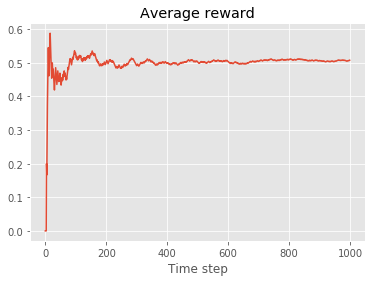

In [5]:
average_reward = np.cumsum(rewards)/(1+np.arange(time_steps))
fig, ax = plt.subplots()

ax.set_title('Average reward');
ax.set_xlabel('Time step');
ax.plot(average_reward);



# **Greedy Action Selection**

Let's implement an agent that always chooses the action it thinks is best.


In [6]:
class GreedyAgent():
    """Greedy agent that chooses always the action it thinks is best.

    If there is a tie the agent chooses randomly among the best actions.

    Attributes:
        n_actions (int): Number of arms of the bandit.
        action_values (numpy.ndarray): A shape-(n_actions,) array which
            contains the estimates of the action values.
        action_counts (numpy.ndarray): A shape-(n_actions,) array counting
            how many times each arm was selected.
        previous_action (int): The previous selected action.
        rng: A random number generator.
    """

    def __init__(self, n_actions):

        self.n_actions = n_actions

        # counts how much each action was selected
        self.action_counts = np.zeros(n_actions)

        # initial estimate of action values
        self.action_values = np.zeros(n_actions)

        self.previous_action = None

        self.rng = default_rng()


    def start(self):
        """Selects the first action."""

        # greedy action selection (greedy policy)
        action = self.argmax(self.action_values)

        # save current action
        self.previous_action = action

        return action


    def step(self, reward):
        """Updates action values using reward signal and selects action.

        Args:
            reward (int): Reward signal.

        Returns:
            action (int): Selected action.
        """
        assert self.previous_action is not None, "Previous action is None."

        # update action value of previous action
        self.action_counts[self.previous_action] += 1
        step_size = 1/self.action_counts[self.previous_action]
        self.action_values[self.previous_action] += step_size * (reward - self.action_values[self.previous_action])

        # greedy action selection (greedy policy)
        action = self.argmax(self.action_values)

        # save current action
        self.previous_action = action

        return action


    def argmax(self, q_values):
        """Return the index of maximum value with ties broken randomly.

        Args:
            q_values (numpy.ndarray): A shape-(n_actions,) array of estimated
                action_values.

        Returns:
            index (int): Index of the maximal value.
        """

        ties = np.flatnonzero(np.isclose(q_values, max(q_values)))
        index = self.rng.choice(ties)

        return index


    def reset(self):
        """Resets the agent and returns first action."""
        self.previous_action = None
        self.action_counts = np.zeros(self.n_actions)
        self.action_values = np.zeros(self.n_actions)
        return self.start()

Let's see how this agent performs.

In [7]:
# create the environment
env = FiveArmedBanditEnv()
n_actions = env.action_space.n

# create the agent
agent = GreedyAgent(n_actions)

# set the number of time steps
time_steps = 1000

# start the simulation
action = agent.start()
rewards = []
actions = [action]
for _ in range(time_steps):
    _, reward, done, _ = env.step(action)
    action = agent.step(reward)
    actions.append(action)
    rewards.append(reward)

# just look at how many times the agent chose each action
agent.action_counts

array([   0.,    0., 1000.,    0.,    0.])

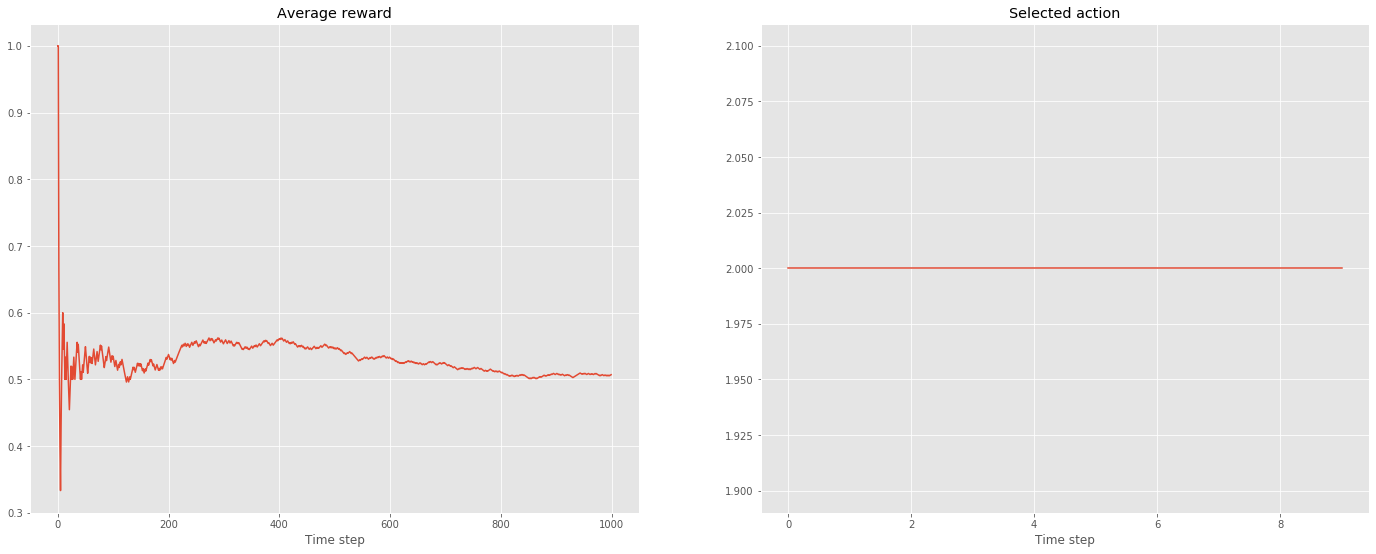

In [8]:
average_reward = np.cumsum(rewards)/(1+np.arange(time_steps))
fig, ax = plt.subplots(1, 2, figsize=(24, 9))

ax[0].set_title('Average reward');
ax[0].set_xlabel('Time step');
ax[0].plot(average_reward);

ax[1].set_title('Selected action');
ax[1].set_xlabel('Time step');
ax[1].plot(actions[:10]);

# **Epsilon-Greedy Action Selection**

The greedy agent can get stuck at a suboptimal action.
To learn which arm is the best, the agent need to explore, i.e. trying actions
which are suboptimal according to his estimations.

In [9]:
class EpsilonGreedyAgent():
    """Implementation of an epsilon-greedy agent.

    With probability 1-epsilon the agent chooses greedy action,
    else the agent chooses random action.

    Attributes:
        n_actions (int): Number of arms of the bandit.
        action_values (numpy.ndarray): A shape-(n_actions,) array which
            contains the estimates of the action values.
        action_counts (numpy.ndarray): A shape-(n_actions,) array counting
            how many times each arm was selected.
        self.epsilon (float): Probability to choose random action
        previous_action (int): The previous selected action.
        rng: A random number generator.
    """

    def __init__(self, n_actions, epsilon=0.1):
        self.n_actions = n_actions

        # counts how much each action was selected
        self.action_counts = np.zeros(n_actions)

        # initial estimate of action values
        self.action_values = np.zeros(n_actions)

        # exploration parameter
        self.epsilon = epsilon

        self.previous_action = None

        self.rng = default_rng()

    def start(self):
        """Selects the first action."""

        # select a random action at the beginning
        action = self.rng.choice(self.n_actions)

        # save current action
        self.previous_action = action

        return action

    def step(self, reward):
        """Updates action values using reward signal and selects action.

        Args:
            reward (int): Reward signal.

        Returns:
            action (int): Selected action.
        """
        assert self.previous_action is not None, "Previous action is None."

        # update action value of previous action
        self.action_counts[self.previous_action] += 1
        step_size = 1/self.action_counts[self.previous_action]
        self.action_values[self.previous_action] += step_size * (reward - self.action_values[self.previous_action])

        # select action according epsilon greedy policy
        if self.rng.random() < self.epsilon:
            action = self.rng.choice(self.n_actions)
        else:
            action = self.argmax(self.action_values)

        # save current action
        self.previous_action = action

        return action


    def argmax(self, q_values):
        """Return the index of maximum value with ties broken randomly.

        Args:
            q_values (numpy.ndarray): A shape-(n_actions,) array of estimated
                action_values.

        Returns:
            index (int): Index of the maximal value.
        """

        ties = np.flatnonzero(np.isclose(q_values, max(q_values)))
        index = np.random.choice(ties)

        return index


    def reset(self):
        """Resets the agent and returns first action."""
        self.previous_action = None
        self.action_counts = np.zeros(self.n_actions)
        self.action_values = np.zeros(self.n_actions)
        return self.start()



In [10]:
# create the environment
env = FiveArmedBanditEnv()
n_actions = env.action_space.n

# create the agent
agent = EpsilonGreedyAgent(n_actions, 0.1)

# set the number simulations and time steps per simulation
n_sim = 500
time_steps = 1000

# start the simulation
rewards = np.zeros((n_sim, time_steps))

for i in range(n_sim):
    action = agent.reset()
    for j in range(time_steps):
        _, reward, done, _ = env.step(action)
        action = agent.step(reward)

        rewards[i, j] = reward

# just look at how many times the agent chose each action
agent.action_counts

array([ 34.,  28.,  96.,  20., 822.])

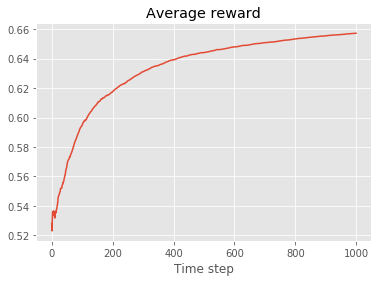

In [11]:
average_reward = np.mean(
    np.cumsum(rewards, axis=1)/(1+np.arange(time_steps)), axis=0)
fig, ax = plt.subplots()

ax.set_title('Average reward')
ax.set_xlabel('Time step')
ax.plot(average_reward)


# **Multi-Armed Bandit**
Let's create a multi-armed bandit. The payoff of each arm is normal distributed
with mean $\mu$ and standard deviation 1.

In [12]:
class MultiArmedBanditEnv(gym.Env):
    """Custom Environment that follows gym interface.

    There are k arms. The payoff of each arm is normal distributed with an
    individual mean mu and fixed standard deviation 1.

    Attributes:
        action_space (Space Object): Inits action space with number of arms.
        arms (list): A list with the payoff probability of each arm.
        rng: A random number generator.

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, k):
        super(MultiArmedBanditEnv, self).__init__()
        # Define action space
        # there are no states in the Bandits Environment
        # Action and State spaces must be gym.spaces objects
        self.action_space = spaces.Discrete(k)

        # random number generator
        self.rng = default_rng()

        # mean payoff of each arm
        self.arms = self.rng.normal(size=k)


    def step(self, action):
        """Returns the payoff of the selected arm.

        Args:
            action (int): Selected arm.
        """

        state = None
        done = False
        info = {}

        reward = self.arms[action] + self.rng.normal()

        return state, reward, done, info


    def reset(self):
        pass


    def render(self, mode='human'):
        pass


In [13]:
# create the environment
k = 10
env = MultiArmedBanditEnv(k)

# create the agent
agent = EpsilonGreedyAgent(k, 0.1)

# set number of time steps
time_steps = 1000

# start the simulation
action = agent.start()
rewards = []
actions = [action]
for _ in range(time_steps):
    _, reward, done, _ = env.step(action)
    action = agent.step(reward)
    rewards.append(reward)


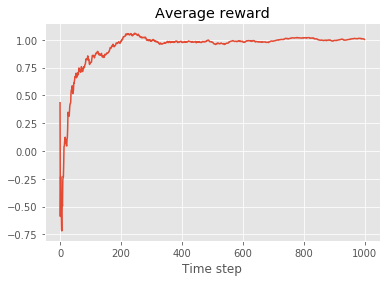

In [14]:
average_reward = np.cumsum(rewards)/(1+np.arange(time_steps))
fig, ax = plt.subplots()

ax.set_title('Average reward');
ax.set_xlabel('Time step');
ax.plot(average_reward);


# **Optimistic Initial Values**
Let's implement an agent with optimistic initial values.

In [54]:
class OptimisticAgent():
    """Implementation of an optimistic agent.

    The agent chooses greedy action, but the initial values are set optimistic.

    Attributes:
        n_actions (int): Number of arms of the bandit.
        action_values (numpy.ndarray): A shape-(n_actions,) array which
            contains the estimates of the action values.
        action_counts (numpy.ndarray): A shape-(n_actions,) array counting
            how many times each arm was selected.
        alpha (float): constant step size (learning rate), alternative to 1/n
        previous_action (int): The previous selected action.
        rng: A random number generator.
    """

    def __init__(self, n_actions):
        self.n_actions = n_actions

        # determine initial action value and initial counts
        initial_action_value = 5
        initial_counts = 10
        self.action_values = np.zeros(self.n_actions) + initial_action_value
        self.action_counts = np.zeros(self.n_actions) + initial_counts

        # constant step size
        self.alpha = 0.2

        self.previous_action = None

        self.rng = default_rng()

    def start(self):
        """Selects the first action."""

        # greedy action selection (greedy policy)
        action = self.argmax(self.action_values)

        # save current action
        self.previous_action = action

        return action


    def step(self, reward):
        """Updates action values using reward signal and selects action.

        Args:
            reward (int): Reward signal.

        Returns:
            action (int): Selected action.
        """
        assert self.previous_action is not None, "Previous action is None."

        # calculate step size, here a constant step size is used
        self.action_counts[self.previous_action] += 1
        step_size = 1/self.action_counts[self.previous_action]
        #step_size = self.alpha

        # update estimate of action value
        self.action_values[self.previous_action] += step_size * (reward - self.action_values[self.previous_action])

        # select greedy action
        action = self.argmax(self.action_values)

        # save current action
        self.previous_action = action

        return action


    def argmax(self, q_values):
        """Return the index of maximum value with ties broken randomly.

        Args:
            q_values (numpy.ndarray): A shape-(n_actions,) array of estimated
                action_values.

        Returns:
            index (int): Index of the maximal value.
        """

        ties = np.flatnonzero(np.isclose(q_values, max(q_values)))
        index = np.random.choice(ties)

        return index


    def reset(self):
        """Resets the agent and returns first action."""
        self.previous_action = None
        self.action_counts = np.zeros(self.n_actions)
        self.action_values = np.zeros(self.n_actions)
        return self.start()


In [75]:
# create the environment
k = 10
env = MultiArmedBanditEnv(k)

# create the agent
agent = OptimisticAgent(k)

# set number of time steps
time_steps = 1000

# start the simulation
action = agent.start()
rewards = []
actions = [action]
for _ in range(time_steps):
    _, reward, done, _ = env.step(action)
    action = agent.step(reward)
    rewards.append(reward)


In [76]:
print('Mean Payoffs: {0}\n'
      'Action counts: {1}\n'
      'Action values: {2}'.format(env.arms, agent.action_counts, agent.action_values))

Mean Payoffs: [ 1.765 -0.785  0.502 -0.126  0.284  0.194 -0.041 -1.329 -0.257  1.036]
Action counts: [824.  21.  36.  23.  34.  33.  29.  20.  24.  56.]
Action values: [1.84  1.82  1.751 1.815 1.824 1.824 1.827 1.801 1.775 1.822]


You can see that the arm with the highest expected reward is chosen the most.


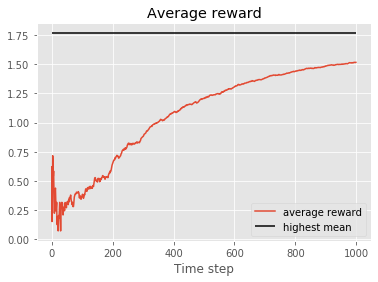

In [81]:
average_reward = np.cumsum(rewards)/(1+np.arange(time_steps))
highest_mean = max(env.arms)

fig, ax = plt.subplots()

ax.set_title('Average reward')
ax.set_xlabel('Time step')
ax.hlines(highest_mean, 0, time_steps, label='highest mean')
ax.plot(average_reward, label='average reward')
ax.legend(loc='lower right');


# **Upper-Confidence Bound**


In [89]:
class UCBAgent():
    """Implementation of an UCB agent.

    The agent is greedy with respect to the upper confidence bound.
    The action counts and action values are initialize as if the agent
    had pulled on every arm once.

    Attributes:
        n_actions (int): Number of arms of the bandit.
        action_values (numpy.ndarray): A shape-(n_actions,) array which
            contains the estimates of the action values.
        action_counts (numpy.ndarray): A shape-(n_actions,) array counting
            how many times each arm was selected.
        previous_action (int): The previous selected action.
        rng: A random number generator.
    """

    def __init__(self, n_actions):
        self.rng = default_rng()

        self.n_actions = n_actions
        self.action_values = self.rng.normal(0, 1, n_actions)
        self.action_counts = np.zeros(self.n_actions) + 1

        # exploration parameter
        self.c = 2

        self.previous_action = None


    def start(self):
        """Selects the first action after initialization."""

        # greedy action selection (greedy policy)
        action = self.argmax(self.action_values)

        # save current action
        self.previous_action = action

        return action


    def step(self, reward):
        """Updates action values using reward signal and selects action.

        Args:
            reward (int): Reward signal.

        Returns:
            action (int): Selected action.
        """
        assert self.previous_action is not None, "Previous action is None."

        # calculate step size, here a constant step size is used
        self.action_counts[self.previous_action] += 1
        step_size = 1/self.action_counts[self.previous_action]

        # update estimate of action value
        self.action_values[self.previous_action] += step_size * (reward - self.action_values[self.previous_action])

        # calculate upper confidence bound for every action
        time_step = np.sum(self.action_counts)
        ucb = self.action_values  \
              + self.c * np.sqrt(np.log(time_step)/self.action_counts)

        # select greedy action
        action = self.argmax(ucb)

        self.previous_action = action

        return action


    def argmax(self, q_values):
        """Return the index of maximum value with ties broken randomly.

        Args:
            q_values (numpy.ndarray): A shape-(n_actions,) array of estimated
                action_values.

        Returns:
            index (int): Index of the maximal value.
        """

        ties = np.flatnonzero(np.isclose(q_values, max(q_values)))
        index = np.random.choice(ties)

        return index


    def reset(self):
        """Resets the agent and returns first action."""
        self.previous_action = None
        self.action_counts = np.zeros(self.n_actions)
        self.action_values = np.zeros(self.n_actions)
        return self.start()

In [87]:
# create the environment
k = 10
env = MultiArmedBanditEnv(k)

# create the agent
agent = UCBAgent(k)

# set number of time steps
time_steps = 1000

# start the simulation
action = agent.start()
rewards = []
actions = [action]
for _ in range(time_steps):
    _, reward, done, _ = env.step(action)
    action = agent.step(reward)
    rewards.append(reward)


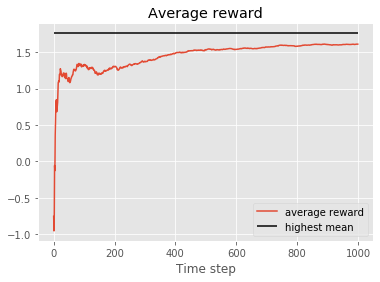

In [88]:
average_reward = np.cumsum(rewards)/(1+np.arange(time_steps))
highest_mean = max(env.arms)

fig, ax = plt.subplots()

ax.set_title('Average reward')
ax.set_xlabel('Time step')
ax.hlines(highest_mean, 0, time_steps, label='highest mean')
ax.plot(average_reward, label='average reward')
ax.legend(loc='lower right');

